In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

# Desciption Project

The aim of the problem is to solve the stochastic differential equation given in the Heston model; a simple and natural method is the use of the discrete time Euler scheme to resolve it as recommended in the article, Here we are implementing the method relative to the two different formulations of the Heston model.

## 1- First formulation of Heston Volatility model

The Euler scheme of the first formulation of Heston model is provided by:

$Y_{t_k}^{n} = Y_0 + \sum_{i=0}^{k-1} (-\frac{1}{2} (V_{t_i}^{n})_{+} + \Delta t + \rho \sqrt{(V_{t_i}^{n})_{+}}(W_{t_{i+1}}-W_{t_i}) + \sqrt{1-\rho ^{2}} \sqrt{(V_{t_i}^{n})_{+}}(W_{t_{i+1}}^{'}-W_{t_i}^{'}),$

$V_{t_k}^{n} = V_0 +\sum_{i=0}^{k-1} (K(t_k-t_i)(\theta - \lambda (V_{t_i}^{n})_{+}) \Delta t + K(t_k-t_i) \nu \sqrt{(V_{t_i}^{n})_{+}} (W_{t_{i+1}}-W_{t_i})).$

We try to visualise the impact of the hypothesis done on $V_t$ on the calculation and the simulation

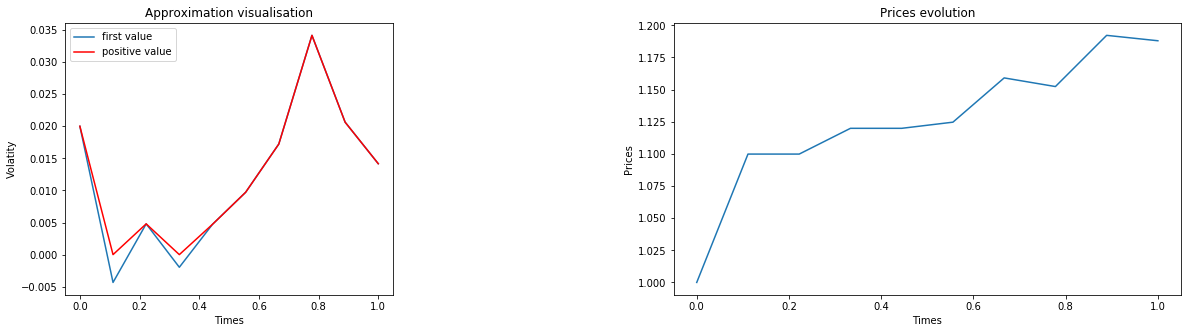

For M = 100 samples and n=10 discret time, price :  0.06027835043497081 With estimation error : 0.005297321588801522


In [8]:
# define the Kernel function
def K(t,C,H):
    return C*t**(H-0.5)

#define the constants
lamb=0.3
vega=0.3
V0=0.02
theta=0.02
rho=-0.7
Y0 = 0
H=0.1
C=1/m.gamma(H+0.5)
n=10# discretisation number
M=100 # samples number
T=1 # time
# define the Brownien
#np.random.seed(0)
pas = T/n
times=np.linspace(0,T,n)
echantillon1=np.random.randn(M,n)
echantillon=np.sqrt(pas)*echantillon1[:,:-1]
W1 =np.cumsum(echantillon, axis=1)
W1=np.hstack((np.array([np.array([0]*M)]).T,W1))
new1 = W1[:,1:]-W1[:,:-1]





#define the volatility samples: M samples
def V_n(theta, lamb, vega, V0,C ,H,W,n,M):
    
    volat_n = np.zeros(shape=(M,n-1))
    volat_n = np.hstack((np.array([np.array([V0]*M)]).T,volat_n)) # initialisation
    time = np.linspace(0,T,n)
    pas=T/n
    
    for k in range(1,n):
        #itération
        inter = V0 +(K(time[k]-time[0:k],C,H)*(pas*(theta-lamb*np.maximum(0,volat_n[:,0:k])) + vega*np.sqrt(np.maximum(0,volat_n[:,0:k]))*W[:,0:k])).sum(axis=1)
        #remplissage du tableau de volatilité
        volat_n[:,k]=inter
    return volat_n





# Calcul de Y_t=log(S_t)
V1_n= V_n(theta, lamb, vega, V0,C ,H,new1,n,M)
V=V1_n[:,:-1]

#one define the estimation of the V_t integration
Xv=pas*np.cumsum(V1_n, axis=1)

echantillon2=np.random.randn(M,n)
echantillon =np.sqrt(pas)*echantillon2[:,:-1]
W2 =np.cumsum(echantillon, axis=1)
W2=np.hstack((np.array([np.array([0]*M)]).T,W2))
new2 = W2[:,1:]-W2[:,:-1]
Y_0 = np.array([Y0]*M)
Y_0 = Y_0.reshape(M,1)
Y=-0.5*pas*np.maximum(0,V)+rho*np.sqrt(np.maximum(0,V))*new1 + np.sqrt(1-rho**2)*np.sqrt(np.maximum(0,V))*new2
Y_n=Y_0 + np.cumsum(Y, axis=1)
Y_n=np.hstack((Y_0,Y_n))
S1_n = np.exp(Y_n)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)

plt.plot(times,V1_n[0], label='first value ')
plt.plot(times,np.maximum(0,V1_n[0]),'r',label='positive value')
plt.xlabel("Times")
plt.ylabel("Volatity")
plt.title("Approximation visualisation")
plt.legend()

plt.subplot(1,2,2)
plt.plot(times,S1_n[0])
plt.xlabel("Times")
plt.ylabel("Prices")
plt.title("Prices evolution")
plt.show()
print('For M = 100 samples and n=10 discret time, price : ',np.mean(np.maximum(0,S1_n[:,-1]-1)),'With estimation error :',np.var(np.maximum(0,S1_n[:,-1]-1)))



## 2- Second formulation of Heston Volatility model

Here we have the Euler scheme for the second formulation

$Y_{t_k}^{n} = Y_0 - \frac{1}{2} Xb_{t_i}^{n} + \rho M_{t_k}^{n} + \sqrt{1-\rho ^{2}} M_{t_k}^{'n},$

$X_{t_k}^{n} = V_0 t_i + \sum_{i=0}^{k-1} K(t_k-t_i)(\theta t_i -\lambda Xb_{t_i}^{n} + \nu M_{t_i}^{n}) \Delta t ,$

$M_{t_i}^{n} = \sum_{i=1}^{k} \sqrt{Xb_{t_i}^{n}-Xb_{t_{i-1}}^{n}}Z_i,$

$M_{t_i}^{'n} = \sum_{i=1}^{k} \sqrt{Xb_{t_i}^{n}-Xb_{t_{i-1}}^{n}}Z_i^{'}$ and $(Z_i,Z_i^{'})$ is a gaussian vector linked to the previous Brownians motions.

Here we try to visualise the error between two ways to calculate $X_t$

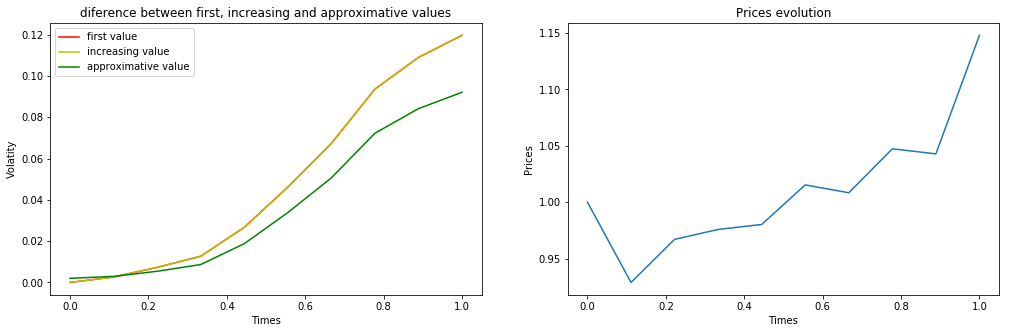

In [11]:
#define the constants
lamb=0.3
vega=0.3
V0=0.02
theta=0.02
rho=-0.7
Y0 = 0
H=0.1
C=1/m.gamma(H+0.5)
n=10
M=100 # samples number
T=1 # time limit
pas = T/n
#define the volatility samples: M samples
def IX_n(theta, lamb, vega, V0,C ,H,echantillon,n,M):
    
    vola_n = np.zeros(shape=(M,n))
    vola_max = np.zeros(shape=(M,n))
    #volat_n = np.hstack((np.array([np.array([V0]*M)]).T,volat_n)) # initialisation
    Martin=np.zeros(shape=(M,n))
    #np.random.seed(0)
    # implementation de la gaussienne 
    time = np.linspace(0,T,n)
    #print(volat_n[0])
    pas=T/n
    maxi=vola_n[:,0].reshape(M,1)
    #print(maxi.shape)
    for k in range(1,n):
        #itération
        #print(volat_n[0],(K(time[k]-time[0:k],C,H)*(theta-lamb*pas*np.maximum(0,volat_n[:,0:k])) + K(time[k]-time[0:k],C,H)*vega*np.sqrt(np.maximum(0,volat_n[:,0:k]))*W[:,0:k]).sum(axis=1))
        inter = V0*time[k]+C*(1/(H+0.5) -1/(H+1.5))*time[k]**(H+1.5)*theta +pas*(K(time[k]-time[0:k],C,H)*(-lamb*vola_max[:,0:k]+vega*Martin[:,0:k])).sum(axis=1)
        inter = inter.reshape(M,1)
        maxi= maxi.reshape(M,1)
        maxi = np.hstack((maxi,inter)).max(axis=1).reshape(M,) # on prend le maximum jusqu'à k
        inter = inter.reshape(M,)
        #print(maxi <inter)
        #remplissage du tableau de l'integrale de la volatilité
        vola_n[:,k]=inter
        vola_max[:,k] = maxi
        Martin[:,k] = (np.sqrt(vola_max[:,1:k+1]-vola_max[:,0:k])*echantillon[:,1:k+1]).sum(axis=1)
    return [vola_n,Martin,vola_max]

# Calcul de Y_t=log(S_t)
times = np.linspace(0,T,n)
A=IX_n(theta, lamb, vega, V0,C ,H,echantillon1,n,M)
X_n = A[0]
M1_n = A[1]
Xb_n =A[2]
# one is building now the second Martingale
Mi =np.cumsum(np.sqrt(Xb_n[:,1:]-Xb_n[:,:-1])*echantillon2[:,1:], axis=1)
M2_n=np.hstack((np.array([np.array([0]*M)]).T,Mi))
# one build Y_n
Y_0 = np.array([Y0]*M)
Y_0 = Y_0.reshape(M,1)
Y_n=Y_0-0.5*Xb_n+rho*M1_n+np.sqrt(1-rho**2)*M2_n
S2_n = np.exp(Y_n)
# Visualisation
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
plt.plot(times,X_n[50],'r', label='first value')
plt.plot(times,Xb_n[50],'y',label='increasing value')
plt.plot(times,Xv[50],'g', label='approximative value')
plt.xlabel("Times")
plt.ylabel("Volatity")
plt.title("diference between first, increasing and approximative values")
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(times,S2_n[0])
plt.xlabel("Times")
plt.ylabel("Prices")
plt.title("Prices evolution")
plt.show()

## Comment :
We can see here with the first plot that there is a small approximation error between the direct approximation of $X_t$ by the integral of $v_t$ and the calculation with the article formula. that can explain the fact that the second formulation of heston model give the best estimation.

## 3- Monte-Carlo Methods for pricing with the asset price

If $f(S_T)$ is the payoff funtion then the option price is $E(f(S_T))$
Thus we take the estimation : 
        $\frac{1}{M} \sum_{m=1}^{M}f(S^{n,m}_T)$ 

## 3-1 European Call options

  $f(S_T) = (S_T-K)_{+}$

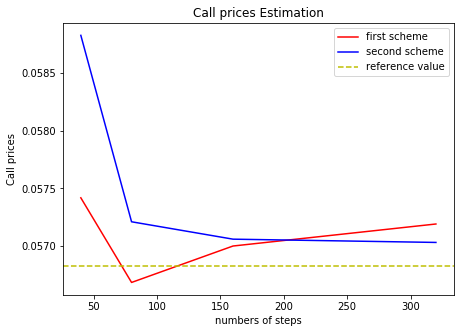

In [119]:
lamb=0.3
vega=0.3
V0=0.02
theta=0.02
rho=-0.7
Y0 = 0
H=0.1
C= 1/m.gamma(H+0.5)
strike=1
M=10000# samples number
T=1.0
reference=0.056832
Lisn=[40,80,160,320]
first=np.zeros(shape=(len(Lisn),1))
second=np.zeros(shape=(len(Lisn),1))
i=0
for n in Lisn:
    np.random.seed(100)
    pas = T/n
    times=np.linspace(0,T,n)
    echantillon1=np.random.normal(0,1, size=(M,n))
    W1 =np.cumsum(np.sqrt(pas)*echantillon1[:,:-1], axis=1)
    W1=np.hstack((np.array([np.array([0]*M)]).T,W1))
    new1 = W1[:,1:]-W1[:,:-1]
    V1 = V_n(theta, lamb, vega, V0,C ,H,new1,n,M)
    V=V1[:,:-1]
    echantillon2=np.random.normal(0,1, size=(M,n))
    W2 =np.cumsum(np.sqrt(pas)*echantillon2[:,:-1], axis=1)
    W2=np.hstack((np.array([np.array([0]*M)]).T,W2))
    new2 = W2[:,1:]-W2[:,:-1]
    Y_0 = np.array([Y0]*M)
    Y_0 = Y_0.reshape(M,1)
    Y=-0.5*pas*np.maximum(0,V)+rho*np.sqrt(np.maximum(0,V))*new1 + np.sqrt(1-rho**2)*np.sqrt(np.maximum(0,V))*new2
    Y_n=Y_0 + np.cumsum(Y, axis=1)
    Y_n=np.hstack((Y_0,Y_n))
    S1_n = np.exp(Y_n)
    first[i]=np.mean(np.maximum(0,S1_n[:,-1]-strike))


    A=IX_n(theta, lamb, vega, V0,C ,H,echantillon1,n,M)
    X_n = A[0]
    M1_n = A[1]
    Xb_n =A[2]
    Mi =np.cumsum(np.sqrt(Xb_n[:,1:]-Xb_n[:,:-1])*echantillon2[:,1:], axis=1)
    M2_n=np.hstack((np.array([np.array([0]*M)]).T,Mi))
    
    Y_0 = np.array([Y0]*M)
    Y_0 = Y_0.reshape(M,1)
    Y_n=Y_0-0.5*Xb_n+rho*M1_n+np.sqrt(1-rho**2)*M2_n
    S2_n = np.exp(Y_n)
    second[i]=np.mean(np.maximum(0,S2_n[:,-1]-strike))
    i+=1

# visualisation
plt.figure(figsize=(7,5))
plt.plot(Lisn,first, color='r', label='first scheme')
plt.plot(Lisn,second,color='b', label='second scheme')
plt.axhline(reference, color='y', linestyle="--", label='reference value')
plt.xlabel("numbers of steps")
plt.ylabel("Call prices")
plt.legend(loc='best')
plt.title("Call prices Estimation")
plt.show()

In [5]:
data = np.array([[0.059642, 0.000245, 7.856192, 0.065483, 0.000279, 7.050599],
[0.058905, 0.000238, 17.419916, 0.059996, 0.000244, 16.307883],
[0.058630, 0.000234, 35.061742, 0.058635, 0.000234, 31.698260],
[0.058344, 0.000232, 70.921679, 0.057363, 0.000228, 60.035371],
[0.058280, 0.000232, 129.678460, 0.056967, 0.000225, 123.884151],
[0.057965, 0.000230, 266.368216, 0.056905, 0.000225, 247.920679],
[0.057858, 0.000229, 582.703205, 0.056897, 0.000225, 482.391579]])

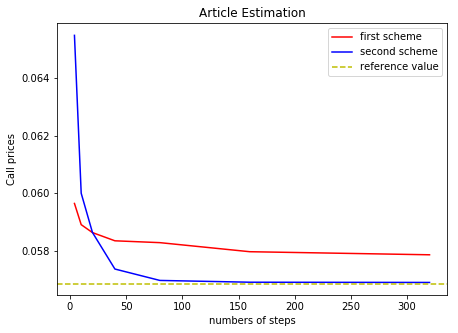

In [10]:
reference=0.056832
Lisn=[4,10,20,40,80,160,320]
plt.figure(figsize=(7,5))
plt.plot(Lisn,data[:,0], color='r', label='first scheme')
plt.plot(Lisn,data[:,3],color='b', label='second scheme')
plt.axhline(reference, color='y', linestyle="--", label='reference value')
plt.xlabel("numbers of steps")
plt.ylabel("Call prices")
plt.legend(loc='best')
plt.title("Article Estimation")
plt.show()

## Comment :
Here we can observe the convergence of the method by using a refence pricing value. The second formulation of heston model give obviously the best estimation.

## 3-2 Asian options

$f(S_T) = (A_T-K)_{+}$
and $A_T = \int_{0}^{T} S_t dt$

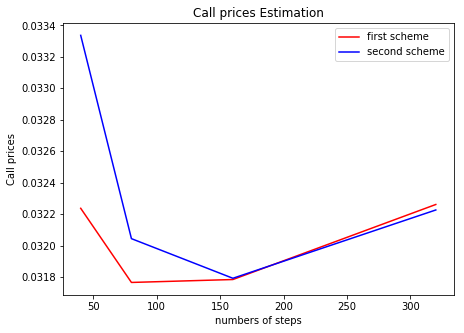

In [120]:
lamb=0.3
vega=0.3
V0=0.02
theta=0.02
rho=-0.7
Y0 = 0
H=0.1
C= 1/m.gamma(H+0.5)
strike=1
M=10000# samples number
T=1.0
reference=0.056832
Lisn=[40,80,160,320]
first=np.zeros(shape=(len(Lisn),1))
second=np.zeros(shape=(len(Lisn),1))
i=0
for n in Lisn:
    np.random.seed(100)
    pas = T/n
    times=np.linspace(0,T,n)
    echantillon1=np.random.normal(0,1, size=(M,n))
    W1 =np.cumsum(np.sqrt(pas)*echantillon1[:,:-1], axis=1)
    W1=np.hstack((np.array([np.array([0]*M)]).T,W1))
    new1 = W1[:,1:]-W1[:,:-1]
    V1 = V_n(theta, lamb, vega, V0,C ,H,new1,n,M)
    V=V1[:,:-1]
    echantillon2=np.random.normal(0,1, size=(M,n))
    W2 =np.cumsum(np.sqrt(pas)*echantillon2[:,:-1], axis=1)
    W2=np.hstack((np.array([np.array([0]*M)]).T,W2))
    new2 = W2[:,1:]-W2[:,:-1]
    Y_0 = np.array([Y0]*M)
    Y_0 = Y_0.reshape(M,1)
    Y=-0.5*pas*np.maximum(0,V)+rho*np.sqrt(np.maximum(0,V))*new1 + np.sqrt(1-rho**2)*np.sqrt(np.maximum(0,V))*new2
    Y_n=Y_0 + np.cumsum(Y, axis=1)
    Y_n=np.hstack((Y_0,Y_n))
    S1_n = np.exp(Y_n)
    A_T=pas*S1_n.sum(axis=1)
    first[i]=np.mean(np.maximum(0,A_T-strike))


    A=IX_n(theta, lamb, vega, V0,C ,H,echantillon1,n,M)
    X_n = A[0]
    M1_n = A[1]
    Xb_n =A[2]
    Mi =np.cumsum(np.sqrt(Xb_n[:,1:]-Xb_n[:,:-1])*echantillon2[:,1:], axis=1)
    M2_n=np.hstack((np.array([np.array([0]*M)]).T,Mi))
    # on construit Y_n
    Y_0 = np.array([Y0]*M)
    Y_0 = Y_0.reshape(M,1)
    Y_n=Y_0-0.5*Xb_n+rho*M1_n+np.sqrt(1-rho**2)*M2_n
    S2_n = np.exp(Y_n)
    A_T=pas*S2_n.sum(axis=1)
    second[i]=np.mean(np.maximum(0,A_T-strike))
    i+=1

#print(first)
#print(second)
plt.figure(figsize=(7,5))
plt.plot(Lisn,first, color='r', label='first scheme')
plt.plot(Lisn,second,color='b', label='second scheme')

plt.xlabel("numbers of steps")
plt.ylabel("Call prices")
plt.legend(loc='best')
plt.title("Call prices Estimation")
plt.show()

In [13]:
data=np.array([[0.036363, 0.000145, 18.126627, 0.038373, 0.000155, 16.334577],
[0.034653, 0.000136, 34.257258, 0.034992, 0.000138, 31.231823],
[0.033647, 0.000132, 68.872156, 0.033387, 0.000130, 61.623905],
[0.033266, 0.000130, 144.862723, 0.032474, 0.000126, 121.671897],
[0.032915, 0.000128, 292.438511, 0.032230, 0.000125, 239.012198],
[0.032479, 0.000127, 563.534848, 0.031907, 0.000124, 450.094275]])

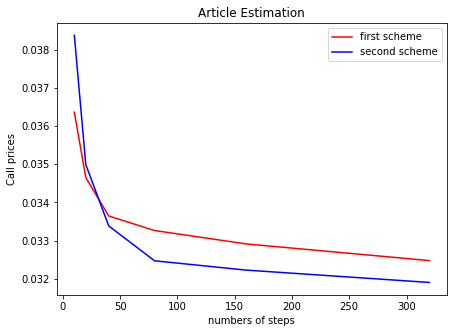

In [14]:
Lisn=[10,20,40,80,160,320]
plt.figure(figsize=(7,5))
plt.plot(Lisn,data[:,0], color='r', label='first scheme')
plt.plot(Lisn,data[:,3],color='b', label='second scheme')
plt.xlabel("numbers of steps")
plt.ylabel("Call prices")
plt.legend(loc='best')
plt.title("Article Estimation")
plt.show()

## 3-3 Lookback option

$f(S_T) = (M_T-K)_{+}$
and 
$M_T = max_{0<t<T}  S_t dt$

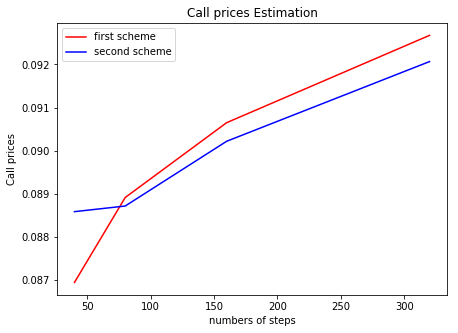

In [121]:
lamb=0.3
vega=0.3
V0=0.02
theta=0.02
rho=-0.7
Y0 = 0
H=0.1
C= 1/m.gamma(H+0.5)
strike=1
M=10000# samples number
T=1.0
reference=0.056832
Lisn=[40,80,160,320]
first=np.zeros(shape=(len(Lisn),1))
second=np.zeros(shape=(len(Lisn),1))
i=0
#np.random.seed(0)
for n in Lisn:
    np.random.seed(100)
    pas = T/n
    times=np.linspace(0,T,n)
    echantillon1=np.random.normal(0,1, size=(M,n))
    W1 =np.cumsum(np.sqrt(pas)*echantillon1[:,:-1], axis=1)
    W1=np.hstack((np.array([np.array([0]*M)]).T,W1))
    new1 = W1[:,1:]-W1[:,:-1]
    #print(V_n(theta, lamb, vega, V0,C ,H,new1,n,M))
    V1 = V_n(theta, lamb, vega, V0,C ,H,new1,n,M)
    V=V1[:,:-1]
    echantillon2=np.random.normal(0,1, size=(M,n))
    W2 =np.cumsum(np.sqrt(pas)*echantillon2[:,:-1], axis=1)
    W2=np.hstack((np.array([np.array([0]*M)]).T,W2))
    new2 = W2[:,1:]-W2[:,:-1]
    Y_0 = np.array([Y0]*M)
    Y_0 = Y_0.reshape(M,1)
    Y=-0.5*pas*np.maximum(0,V)+rho*np.sqrt(np.maximum(0,V))*new1 + np.sqrt(1-rho**2)*np.sqrt(np.maximum(0,V))*new2
    Y_n=Y_0 + np.cumsum(Y, axis=1)
    Y_n=np.hstack((Y_0,Y_n))
    S1_n = np.exp(Y_n)
    M_T=S1_n.max(axis=1)
    first[i]=np.mean(np.maximum(0,M_T-strike))


    A=IX_n(theta, lamb, vega, V0,C ,H,echantillon1,n,M)
    X_n = A[0]
    M1_n = A[1]
    Xb_n =A[2]
    """X_n = np.cumsum(V1,axis=1)
    Xb_n =pas*np.cumsum(np.maximum(0,V1), axis=1)"""
    # on construit maintemant la deuxième Martingale
    #np.random.seed(0)
    #Mj=np.cumsum(np.sqrt(Xb_n[:,1:]-Xb_n[:,:-1])*echantillon1[:,1:], axis=1)
    #M1_n = np.hstack((np.array([np.array([0]*M)]).T,Mj))
    Mi =np.cumsum(np.sqrt(Xb_n[:,1:]-Xb_n[:,:-1])*echantillon2[:,1:], axis=1)
    M2_n=np.hstack((np.array([np.array([0]*M)]).T,Mi))
    # on construit Y_n
    Y_0 = np.array([Y0]*M)
    Y_0 = Y_0.reshape(M,1)
    Y_n=Y_0-0.5*Xb_n+rho*M1_n+np.sqrt(1-rho**2)*M2_n
    S2_n = np.exp(Y_n)
    M_T=S2_n.max(axis=1)
    second[i]=np.mean(np.maximum(0,M_T-strike))
    i+=1

#print(first)
#print(second)
plt.figure(figsize=(7,5))
plt.plot(Lisn,first, color='r', label='first scheme')
plt.plot(Lisn,second,color='b', label='second scheme')
#plt.axhline(reference, color='y', linestyle="--", label='reference value')
plt.xlabel("numbers of steps")
plt.ylabel("Call prices")
plt.legend(loc='best')
plt.title("Call prices Estimation")
plt.show()

In [15]:
data=np.array([[0.081591, 0.000234, 18.394217, 0.076769, 0.000238, 17.260538],
[0.085409, 0.000228, 33.485885, 0.079742, 0.000226, 33.581574],
[0.088502, 0.000226, 66.453965, 0.083297, 0.000222, 64.918632],
[0.090927, 0.000225, 130.933455, 0.086043, 0.000219, 124.431435],
[0.092118, 0.000223, 290.638306, 0.088685, 0.000219, 246.881069],
[0.092904, 0.000222, 558.946791, 0.090338, 0.000219, 492.821703]])

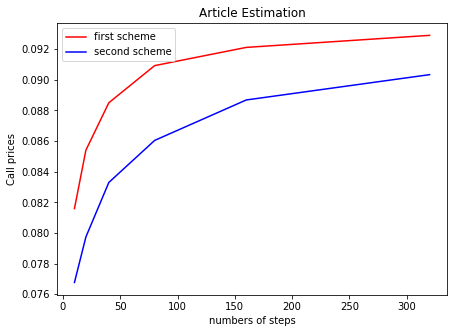

In [16]:
Lisn=[10,20,40,80,160,320]
plt.figure(figsize=(7,5))
plt.plot(Lisn,data[:,0], color='r', label='first scheme')
plt.plot(Lisn,data[:,3],color='b', label='second scheme')
plt.xlabel("numbers of steps")
plt.ylabel("Call prices")
plt.legend(loc='best')
plt.title("Article Estimation")
plt.show()

## 4- Pricing with the variance X_T

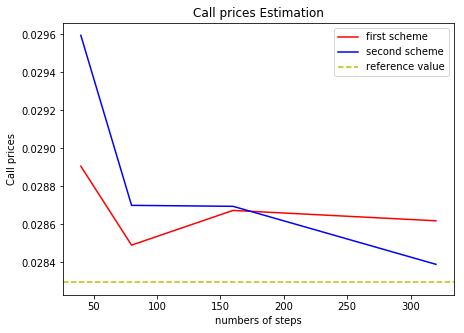

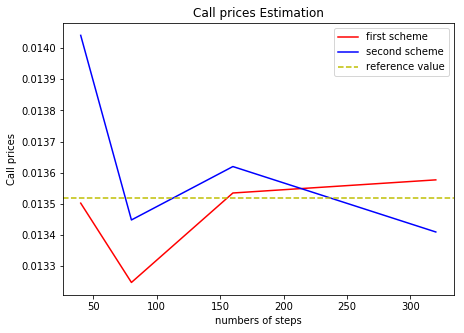

In [148]:
lamb=0.3
vega=0.3
V0=0.02
theta=0.02
rho=-0.7
Y0 = 0
H=0.1
C= 1/m.gamma(H+0.5)
strike=1
M=10000# samples number
T=1.0
reference=0.028295
reference1=0.013517
Lisn=[40,80,160,320]
first=np.zeros(shape=(len(Lisn),1))
first1=np.zeros(shape=(len(Lisn),1))
second=np.zeros(shape=(len(Lisn),1))
second1=np.zeros(shape=(len(Lisn),1))
i=0
#np.random.seed(0)
for n in Lisn:
    np.random.seed(150)
    pas = T/n
    times=np.linspace(0,T,n)
    echantillon1=np.random.normal(0,1, size=(M,n))
    W1 =np.cumsum(np.sqrt(pas)*echantillon1[:,:-1], axis=1)
    W1=np.hstack((np.array([np.array([0]*M)]).T,W1))
    new1 = W1[:,1:]-W1[:,:-1]
    #print(V_n(theta, lamb, vega, V0,C ,H,new1,n,M))
    V1 = V_n(theta, lamb, vega, V0,C ,H,new1,n,M)
    first[i]=np.mean(pas*np.maximum(0,V1).sum(axis=1))
    first1[i]=np.mean(np.maximum(0,pas*np.maximum(0,V1).sum(axis=1)-V0))


    A=IX_n(theta, lamb, vega, V0,C ,H,echantillon1,n,M)
    X_n = A[0]
    M1_n = A[1]
    Xb_n =A[2]
    second[i]=np.mean(Xb_n[:,-1])
    second1[i]=np.mean(np.maximum(0,Xb_n[:,-1]-V0))
    i+=1

#print(first)
#print(second)
plt.figure(figsize=(7,5))
plt.plot(Lisn,first, color='r', label='first scheme')
plt.plot(Lisn,second,color='b', label='second scheme')
plt.axhline(reference, color='y', linestyle="--", label='reference value')
plt.xlabel("numbers of steps")
plt.ylabel("Call prices")
plt.legend(loc='best')
plt.title("Call prices Estimation")
plt.show()
plt.figure(figsize=(7,5))
plt.plot(Lisn,first1, color='r', label='first scheme')
plt.plot(Lisn,second1,color='b', label='second scheme')
plt.axhline(reference1, color='y', linestyle="--", label='reference value')
plt.xlabel("numbers of steps")
plt.ylabel("Call prices")
plt.legend(loc='best')
plt.title("Call prices Estimation")
plt.show()

In [18]:
data = np.array([[0.033967, 0.000080, 8.389909, 0.033565, 0.000090, 8.291969],
[0.030781, 0.000085, 17.706663, 0.030522, 0.000098, 17.645600],
[0.029736, 0.000088, 33.061506, 0.029387, 0.000098, 31.253372],
[0.029218, 0.000091, 69.696746, 0.028756, 0.000098, 59.500006],
[0.029165, 0.000093, 132.443006, 0.028527, 0.000097, 123.055661],
[0.028875, 0.000095, 267.132785, 0.028477, 0.000098, 248.295026],
[0.028685, 0.000094, 575.724998, 0.028328, 0.000098, 486.069715]])

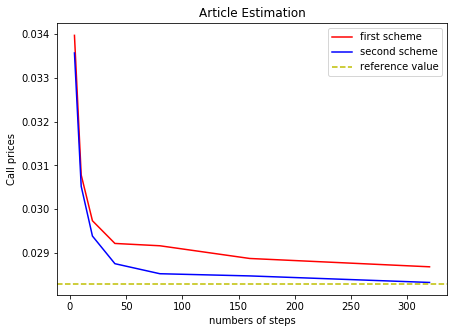

In [19]:
reference=0.028295
Lisn=[4,10,20,40,80,160,320]
plt.figure(figsize=(7,5))
plt.plot(Lisn,data[:,0], color='r', label='first scheme')
plt.plot(Lisn,data[:,3],color='b', label='second scheme')
plt.axhline(reference, color='y', linestyle="--", label='reference value')
plt.xlabel("numbers of steps")
plt.ylabel("Call prices")
plt.legend(loc='best')
plt.title("Article Estimation")
plt.show()

In [20]:
data = np.array([[0.016940, 0.000074, 8.425556, 0.017096, 0.000081, 7.537352],
[0.014542, 0.000076, 18.414490, 0.015131, 0.000088, 15.891882],
[0.014043, 0.000079, 36.577253, 0.014254, 0.000088, 30.900766],
[0.013752, 0.000082, 70.948186, 0.013905, 0.000088, 59.677628],
[0.013841, 0.000084, 144.526883, 0.013770, 0.000088, 118.789620],
[0.013705, 0.000085, 273.132594, 0.013775, 0.000088, 230.445799],
[0.013641, 0.000085, 585.570704, 0.013600, 0.000088, 471.164119]])

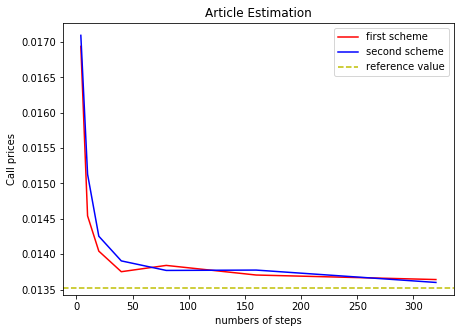

In [21]:
reference=0.013517
Lisn=[4,10,20,40,80,160,320]
plt.figure(figsize=(7,5))
plt.plot(Lisn,data[:,0], color='r', label='first scheme')
plt.plot(Lisn,data[:,3],color='b', label='second scheme')
plt.axhline(reference, color='y', linestyle="--", label='reference value')
plt.xlabel("numbers of steps")
plt.ylabel("Call prices")
plt.legend(loc='best')
plt.title("Article Estimation")
plt.show()

## Comment :

In all the last estimations one can remark the importance of the strongh law of the greatest numbers. because, when the samples number is not enough one can't really see the convergence. Notice that the number of discret time is also important for the approximation.